In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st

import numpy as np
np.random.seed(1555)
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Reshape,Dropout,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU,PReLU,SReLU
from keras.regularizers import l1,l2
from keras.constraints import nonneg
# from keras.callbacks import EarlyStopping
# earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

import math
import time
import datetime

import sklearn.linear_model as lm
from sklearn import cluster, datasets, metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

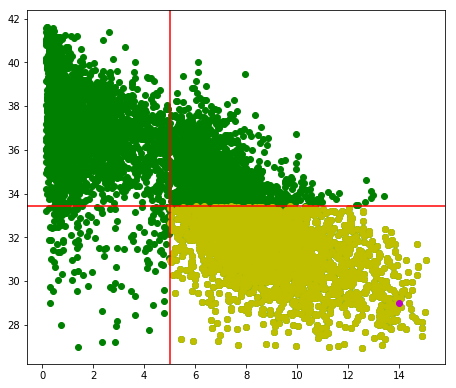

In [3]:
vd_df = pd.read_csv('cleanoutwvd.csv')
vd_df_cp = vd_df.copy()
vd_df_cp_drop = vd_df_cp.drop(['YY','day','date','time','direct','lane','eqflow','fakeornot','realvd'],axis=1)
sortby_num = 0
vddf_drop_sortnum = vd_df_cp_drop[vd_df_cp_drop.sortby == sortby_num]

'''pick one vd for quick look this vd's pattern is easy to predict or not, overlap everyweek'''
# plt.figure(figsize=(7.5,4.5))
# for x in range(0,len(vddf_drop_sortnum),168):
#     plt.plot(vddf_drop_sortnum.speed[x:x+168].values)
# # same vd, but look in whole way.
# plt.figure(figsize=(7.5,4.5))    
# vddf_drop_sortnum = vd_df_cp_drop[vd_df_cp_drop.sortby == sortby_num]
# plt.plot(vddf_drop_sortnum.speed.values)

speed_quantile = vddf_drop_sortnum.speed.quantile(0.4);
traffic_jam_area = vddf_drop_sortnum.ix[(vddf_drop_sortnum.speed<speed_quantile)&(vddf_drop_sortnum.accu>5)].copy()
predict_accu =14
predict_speed = 29

plt.figure(figsize = (7.5,6.5))
plt.plot(vddf_drop_sortnum.accu,vddf_drop_sortnum.speed, 'go')
plt.plot(traffic_jam_area.accu,traffic_jam_area.speed, 'yo')
plt.axhline(y = speed_quantile, xmin = 0, xmax = vddf_drop_sortnum.accu.count(), color = 'r')
plt.axvline(5, color='r')
plt.plot(predict_accu,predict_speed,'mo')

# speed_min = vddf_drop_sortnum.speed.min()
# accu_max = vddf_drop_sortnum.accu.max()
# where_y = speed_quantile - speed_min
# where_x = accu_max - 5

# xp = accu_max - predict_accu
# yp = predict_speed - speed_min

# if (predict_accu>5)&(predict_speed<speed_quantile):
#     print ((1-(xp/where_x))/2)+((1-(yp/where_y))/2)
# else:
#     print 0

In [4]:
"""pre_value_df = vd_df_cp.drop(['YY','lane','fakeornot','date','eqflow'],axis=1).groupby('sortby').head(168)
pre_value_df = pre_value_df.reset_index(drop=True)

pre_value_df['jam_percent']=0
pre_value_df['congest']=0
# pre_value_df
#計算現有的VD的塞車率
#利用sortby

for sortby in vd_df_cp.sortby.unique().tolist():
    
    vddf_cp_sortnum = vd_df_cp[vd_df_cp.sortby == sortby]
    speed_quantile = vddf_cp_sortnum.speed.quantile(0.4);
    traffic_jam_area = vddf_cp_sortnum.ix[(vddf_cp_sortnum.speed<speed_quantile)&(vddf_cp_sortnum.accu>5)].copy()
    pre_value_df_sortnum = pre_value_df[pre_value_df.sortby == sortby]

    for dd,tt in pre_value_df_sortnum[['day','time']].values.tolist():
        alldaynum=vddf_cp_sortnum[(vddf_cp_sortnum.day==dd)&(vddf_cp_sortnum.time==tt)].count()[0]
        jamdaynum=traffic_jam_area[(traffic_jam_area.day==dd)&(traffic_jam_area.time==tt)].count()[0]
        condition =(pre_value_df.sortby==sortby)&(pre_value_df.time==tt)&(pre_value_df.day==dd)
        pre_value_df.ix[condition,'jam_percent']=round((float(jamdaynum)/alldaynum),4)
    print sortby
"""


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0


In [16]:
pre_value_df = vd_df_cp.drop(['YY','lane','fakeornot','date','eqflow'],axis=1).groupby('sortby').head(168)
pre_value_df = pre_value_df.reset_index(drop=True)

pre_value_df['jam_percent']=0
pre_value_df['congest']=0
# pre_value_df
#計算現有的VD的塞車率
#利用sortby

for sortby in vd_df_cp.sortby.unique().tolist():
# sortby=0
    vddf_cp_sortnum = vd_df_cp[vd_df_cp.sortby == sortby]

    traffic_jam_area = vddf_cp_sortnum.ix[(vddf_cp_sortnum.speed<speed_quantile)&(vddf_cp_sortnum.accu>5)].copy()
    pre_value_df_sortnum = pre_value_df[pre_value_df.sortby == sortby]
    speed_quantile = vddf_cp_sortnum.speed.quantile(0.4);
    speed_min = vddf_cp_sortnum.speed.min()
    accu_max = vddf_cp_sortnum.accu.max()
    where_y = speed_quantile - speed_min
    where_x = accu_max - 5

    for dd,tt in pre_value_df_sortnum[['day','time']].values.tolist():
                # 計算塞車率用
        alldaynum=vddf_cp_sortnum[(vddf_cp_sortnum.day==dd)&(vddf_cp_sortnum.time==tt)].count()[0]
        jamdaynum=traffic_jam_area[(traffic_jam_area.day==dd)&(traffic_jam_area.time==tt)].count()[0]
        # 條件判斷 
        condition_sort =(pre_value_df.sortby==sortby)&(pre_value_df.time==tt)&(pre_value_df.day==dd)

        pre_value_df.ix[condition_sort,'jam_percent']=round((float(jamdaynum)/alldaynum),4)
        predict_accu = pre_value_df.ix[condition_sort,'accu'].values[0]

        predict_speed = pre_value_df.ix[condition_sort,'speed'].values[0]
        #算雍塞度
        xp = accu_max - predict_accu
        yp = predict_speed - speed_min
        congest = ((1-(xp/where_x))/2)+((1-(yp/where_y))/2)
        if (predict_accu>5)&(predict_speed<speed_quantile):
            pre_value_df.ix[condition_sort,'congest']=round(congest,4)
        else:
            pass
    print sortby



0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0


In [18]:
pre_value_df.to_csv('neihu_jam.csv',index =False)

In [10]:
pre_value_df.head(168)

,realvd,sortby,direct,day,time,speed,accu,jam_percent,congest
0,VTZY920,0.0,1,4,0,38.251442,2.405000,0.0,0.0000
1,VTZY920,0.0,1,4,1,38.657047,1.380000,0.0,0.0000
2,VTZY920,0.0,1,4,2,38.719640,0.650000,0.0,0.0000
3,VTZY920,0.0,1,4,3,36.774548,0.470000,0.0,0.0000
4,VTZY920,0.0,1,4,4,38.172173,0.625000,0.0,0.0000
5,VTZY920,0.0,1,4,5,34.717144,0.355000,0.0,0.0000
6,VTZY920,0.0,1,4,6,38.709030,0.600000,0.0,0.0000
7,VTZY920,0.0,1,4,7,35.480774,3.005000,0.0,0.0000
8,VTZY920,0.0,1,4,8,35.205597,6.360000,0.0,0.0000
9,VTZY920,0.0,1,4,9,36.073368,8.014999,0.0,0.0000


In [ ]:
speed_min = vddf_drop_sortnum.speed.min()
accu_max = vddf_drop_sortnum.accu.max()
where_y = speed_quantile - speed_min
where_x = accu_max - 5

xp = accu_max - predict_accu
yp = predict_speed - speed_min

if (predict_accu>5)&(predict_speed<speed_quantile):
    print ((1-(xp/where_x))/2)+((1-(yp/where_y))/2)
else:
    print 0

In [104]:
pre_value_df
# pre_value_df.ix[(pre_value_df.time==0)&(pre_value_df.day==4),'accu']

,realvd,sortby,direct,day,time,speed,accu,jam_percent,congest
0,VTZY920,0.0,1,4,0,38.251442,2.405000,0.0000,0
1,VTZY920,0.0,1,4,1,38.657047,1.380000,0.0000,0
2,VTZY920,0.0,1,4,2,38.719640,0.650000,0.0000,0
3,VTZY920,0.0,1,4,3,36.774548,0.470000,0.0000,0
4,VTZY920,0.0,1,4,4,38.172173,0.625000,0.0000,0
5,VTZY920,0.0,1,4,5,34.717144,0.355000,0.0000,0
6,VTZY920,0.0,1,4,6,38.709030,0.600000,0.0000,0
7,VTZY920,0.0,1,4,7,35.480774,3.005000,0.0000,0
8,VTZY920,0.0,1,4,8,35.205597,6.360000,0.1707,0
9,VTZY920,0.0,1,4,9,36.073368,8.014999,0.0976,0


In [92]:
# 要如何驗證呢？

sortby = 7

value_df_sortnum = pre_value_df[pre_value_df.sortby == sortby]

vd_sortnum_cp = vd_df_cp[vd_df_cp.sortby == sortby]
print vd_sortnum_cp.realvd.unique()[0]
print vd_sortnum_cp.direct.unique()[0]
speed_quantile = vd_sortnum_cp.speed.quantile(0.4);
traffic_jam_area = vd_sortnum_cp.ix[(vd_sortnum_cp.speed<speed_quantile)&(vd_sortnum_cp.accu>5)].copy()
    
# i=4;j=8;n=18
# rush = [(i-1,j-1),(i-1,j),(i-1,j+1),(i-1,j+2),(i-1,n-1),(i-1,n),(i-1,n+1),(i-1,n+2)]

for dd,tt in value_df_sortnum[['day','time']].values.tolist():
    alldaynum=vd_sortnum_cp[(vd_sortnum_cp.day==dd)&(vd_sortnum_cp.time==tt)].count()[0]
    jamdaynum=traffic_jam_area[(traffic_jam_area.day==dd)&(traffic_jam_area.time==tt)].count()[0]
    print '星期',int(dd+1),'_',int(tt),'\t點',round((float(jamdaynum)/alldaynum),4)*100,'%';
    

# print '星期',int(dd+1),'_',int(tt),'點'
# print round((float(jamdaynum)/alldaynum),4)*100,'%'
# ,wwp[(wwp.day==dd)&(wwp.time==tt)].eqflow.mean()


VQKWL00
3
星期 5 _ 0 	點 39.02 %
星期 5 _ 1 	點 0.0 %
星期 5 _ 2 	點 0.0 %
星期 5 _ 3 	點 0.0 %
星期 5 _ 4 	點 0.0 %
星期 5 _ 5 	點 0.0 %
星期 5 _ 6 	點 0.0 %
星期 5 _ 7 	點 12.2 %
星期 5 _ 8 	點 4.88 %
星期 5 _ 9 	點 12.2 %
星期 5 _ 10 	點 85.37 %
星期 5 _ 11 	點 82.93 %
星期 5 _ 12 	點 65.85 %
星期 5 _ 13 	點 29.27 %
星期 5 _ 14 	點 60.98 %
星期 5 _ 15 	點 68.29 %
星期 5 _ 16 	點 68.29 %
星期 5 _ 17 	點 73.17 %
星期 5 _ 18 	點 92.68 %
星期 5 _ 19 	點 92.68 %
星期 5 _ 20 	點 92.68 %
星期 5 _ 21 	點 75.61 %
星期 5 _ 22 	點 70.73 %
星期 5 _ 23 	點 14.63 %
星期 6 _ 0 	點 78.05 %
星期 6 _ 1 	點 0.0 %
星期 6 _ 2 	點 0.0 %
星期 6 _ 3 	點 0.0 %
星期 6 _ 4 	點 0.0 %
星期 6 _ 5 	點 0.0 %
星期 6 _ 6 	點 0.0 %
星期 6 _ 7 	點 4.88 %
星期 6 _ 8 	點 0.0 %
星期 6 _ 9 	點 7.32 %
星期 6 _ 10 	點 17.07 %
星期 6 _ 11 	點 43.9 %
星期 6 _ 12 	點 29.27 %
星期 6 _ 13 	點 12.2 %
星期 6 _ 14 	點 9.76 %
星期 6 _ 15 	點 21.95 %
星期 6 _ 16 	點 21.95 %
星期 6 _ 17 	點 19.51 %
星期 6 _ 18 	點 21.95 %
星期 6 _ 19 	點 34.15 %
星期 6 _ 20 	點 53.66 %
星期 6 _ 21 	點 43.9 %
星期 6 _ 22 	點 39.02 %
星期 6 _ 23 	點 4.88 %
星期 7 _ 0 	點 58.54 %
星期 7 _ 1 	點 0.0 %


In [68]:
# pre_value_df[pre_value_df.sortby==sortby]
# pre_value_df[pre_value_df.realvd=='VQKWL00']
# pre_value_df

,realvd,sortby,direct,day,time,speed,accu,jam_percent,congest
1176,VQKWL00,7.0,3,4,0,43.266556,4.785000,0.3902,0
1177,VQKWL00,7.0,3,4,1,43.574740,3.630000,0.0000,0
1178,VQKWL00,7.0,3,4,2,43.123775,2.245000,0.0000,0
1179,VQKWL00,7.0,3,4,3,43.905807,1.030000,0.0000,0
1180,VQKWL00,7.0,3,4,4,48.837112,0.915000,0.0000,0
1181,VQKWL00,7.0,3,4,5,44.233322,0.955000,0.0000,0
1182,VQKWL00,7.0,3,4,6,45.774128,2.135000,0.0000,0
1183,VQKWL00,7.0,3,4,7,42.777430,7.530000,0.1220,0
1184,VQKWL00,7.0,3,4,8,44.133110,12.340000,0.0488,0
1185,VQKWL00,7.0,3,4,9,44.580510,11.595000,0.1220,0


In [ ]:
# 看當量數，因為凌晨的塞車率居然很高！？，但當量不高，所以之後要用當量去核對

vd_df_cp[(vd_df_cp.sortby==7)&(vd_df_cp.time==0)]
# vd_df_cp[(vd_df_cp.sortby==7)].describe()


plt.figure(figsize = (7.5,6.5))
plt.plot(vd_df_cp[(vd_df_cp.sortby==7)].eqflow,'go')
plt.plot(vd_df_cp[(vd_df_cp.sortby==7)&(vd_df_cp.time==0)].eqflow,'ro')
plt.axhline(y = vd_df_cp[(vd_df_cp.sortby==7)].eqflow.mean(), xmin = 0, xmax = 55000, color = 'r')